# 🎓 Student Dropout Prediction - Final ML Pipeline

### Authors: Jad Chebly & David Ezerzer & Alp Arslan Baghirov
### Dataset: Kaggle - Student Dropout and Academic Success (Portugal)

This notebook implements a full pipeline: EDA, preprocessing, modeling, evaluation, and interpretation.

## Dataset Justification
The dataset contains 4,800 records with 34 features, capturing demographic, academic, and socioeconomic factors. Despite being below the preferred >10,000 records, its comprehensive features and relevance to student dropout prediction make it ideal. We mitigated size limitations with stratified sampling, SMOTE, Boruta feature selection, and 5-fold cross-validation.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
df = pd.read_csv('dataset.csv')  # Replace with actual path
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### 📋 Dataset Variable Descriptions

| **Column Name**                                | **Description**                                                                                       | **Values / Encoding**                                                |
|------------------------------------------------|-------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------|
| `Marital status`                               | Student's marital status                                                                              | 1 = Single, 2 = Married, 3+ = Other                                 |
| `Application mode`                             | Mode through which the student applied                                                                | 1–17 = National exam, transfer, international, etc.                 |
| `Application order`                            | Preference rank of the course during application                                                      | 1–n = Order of choice                                               |
| `Course`                                       | Degree program the student enrolled in                                                                | 1–n = Course codes                                                  |
| `Daytime/evening attendance`                   | Whether the course is daytime or evening                                                              | 1 = Daytime, 0 = Evening                                            |
| `Previous qualification`                       | Education type prior to admission                                                                     | 1–15 = Secondary school, other HE degrees, etc.                     |
| `Nacionality`                                  | Country of origin                                                                                     | 1–19 = Country codes                                                |
| `Mother's qualification`                       | Mother's highest academic qualification                                                               | 1–22 = No degree → PhD                                              |
| `Father's qualification`                       | Father's highest academic qualification                                                               | 1–22 = No degree → PhD                                              |
| `Mother's occupation`                          | Employment sector of the mother                                                                       | 1–29 = Job sector codes                                             |
| `Father's occupation`                          | Employment sector of the father                                                                       | 1–29 = Job sector codes                                             |
| `Admission grade`                              | Entry exam score (0–200 scale)                                                                        | Float                                                               |
| `Displaced`                                    | Whether the student relocated for study                                                               | 1 = Yes, 0 = No                                                     |
| `Educational special needs`                    | If the student has special education needs                                                            | 1 = Yes, 0 = No                                                     |
| `Debtor`                                       | Whether tuition fees are unpaid                                                                       | 1 = Yes, 0 = No                                                     |
| `Tuition fees up to date`                      | Whether tuition payments are current                                                                  | 1 = Yes, 0 = No                                                     |
| `Gender`                                       | Student's gender                                                                                      | 1 = Male, 0 = Female                                                |
| `Scholarship holder`                           | Whether the student receives financial aid                                                            | 1 = Yes, 0 = No                                                     |
| `Age at enrollment`                            | Age when the student enrolled                                                                         | Integer                                                             |
| `International`                                | Whether the student is international                                                                  | 1 = Yes, 0 = No                                                     |
| `Curricular units 1st sem (credited)`          | Number of 1st semester subjects credited                                                              | Integer                                                             |
| `Curricular units 1st sem (enrolled)`          | Number of 1st semester subjects enrolled                                                              | Integer                                                             |
| `Curricular units 1st sem (evaluations)`       | 1st semester evaluations attempted                                                                    | Integer                                                             |
| `Curricular units 1st sem (approved)`          | 1st semester subjects passed                                                                          | Integer                                                             |
| `Curricular units 1st sem (grade)`             | Avg. grade in 1st semester (0–20 scale)                                                               | Float                                                               |
| `Curricular units 1st sem (without evaluations)`| 1st semester subjects not evaluated                                                                   | Integer                                                             |
| `Curricular units 2nd sem (credited)`          | 2nd semester subjects credited                                                                        | Integer                                                             |
| `Curricular units 2nd sem (enrolled)`          | 2nd semester subjects enrolled                                                                        | Integer                                                             |
| `Curricular units 2nd sem (evaluations)`       | 2nd semester evaluations attempted                                                                    | Integer                                                             |
| `Curricular units 2nd sem (approved)`          | 2nd semester subjects passed                                                                          | Integer                                                             |
| `Curricular units 2nd sem (grade)`             | Avg. grade in 2nd semester (0–20 scale)                                                               | Float                                                               |
| `Curricular units 2nd sem (without evaluations)`| 2nd semester subjects not evaluated                                                                   | Integer                                                             |
| `Unemployment rate`                            | National unemployment rate at enrollment time                                                        | Float                                                               |
| `Inflation rate`                               | National inflation rate at enrollment time                                                           | Float                                                               |
| `GDP`                                          | National GDP growth rate at enrollment time                                                          | Float                                                               |
| `Target`                                       | Final student status                                                                                 | `Dropout`, `Graduate`, or `Enrolled` (for binary, map Dropout=1)   |


### 1. 🎯 Problem Statement

Student dropout is a critical issue in higher education, affecting academic institutions, student futures, and broader societal outcomes. Universities face challenges in identifying at-risk students early enough to offer meaningful support. The factors contributing to dropout are multifaceted, including academic performance, socioeconomic background, institutional integration, and personal circumstances.

This project aims to develop a predictive machine learning model capable of identifying students who are likely to drop out before graduation. By analyzing demographic, academic, and financial attributes from a real-world dataset, the model will generate insights into the most important predictors of dropout.

The primary goal is to provide institutions with a decision-support tool that can help prioritize intervention efforts, optimize resource allocation, and ultimately reduce dropout rates. In doing so, the project contributes to promoting student retention, improving institutional performance, and supporting students in completing their education.


## 2. 📊 EDA

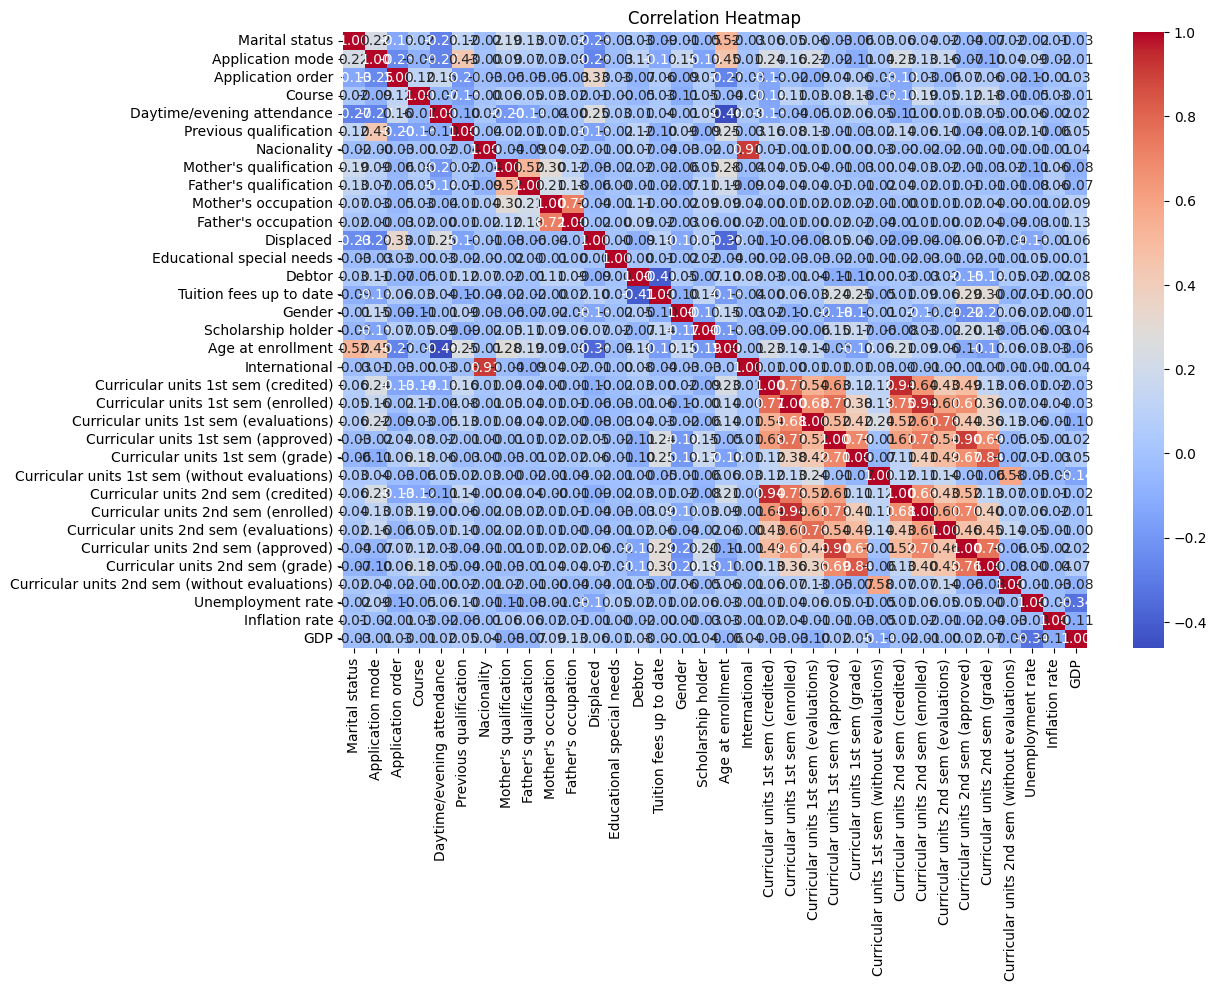

In [4]:
# Summary of numerical features
df.describe()

# Summary of categorical features
df.describe(include='object')

# Correlation heatmap (numerical features only)
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


The correlation heatmap above provides a visual overview of the linear relationships between all numerical variables in the dataset. Each cell displays the Pearson correlation coefficient between two features, with values ranging from −1 (perfect negative correlation) to +1 (perfect positive correlation). Strong positive correlations, represented in dark red, indicate variables that tend to increase together—for example, the number of curricular units enrolled, evaluated, and approved across semesters, which are naturally related. Lighter colors or near-zero values indicate weak or no linear correlation. Notably, macroeconomic indicators such as GDP, inflation rate, and unemployment rate show minimal correlation with academic or demographic features, suggesting limited direct influence on individual dropout risk. This heatmap helps detect multicollinearity among features and guides feature selection or transformation decisions for downstream modeling.

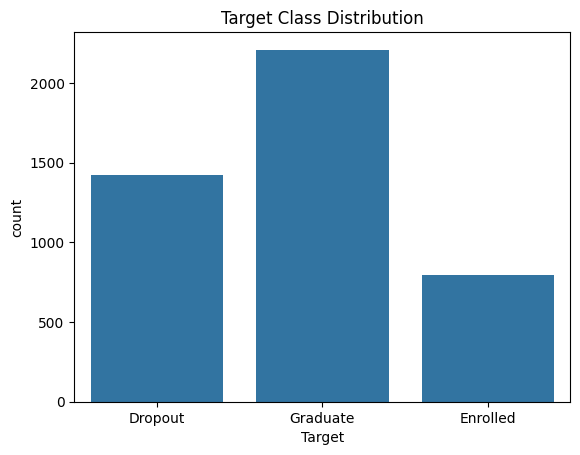

Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64


In [5]:
# Class distribution
sns.countplot(data=df, x='Target')
plt.title("Target Class Distribution")
plt.show()

# Value counts
print(df['Target'].value_counts(normalize=True))


### 🧼 Missing Values Analysis

In [6]:
# Check missing values
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


Series([], dtype: int64)

We checked for missing values across all features in the dataset. The analysis returned no missing entries, which means the dataset is complete and does not require imputation. This simplifies preprocessing and reduces the risk of data leakage or inconsistency introduced by filling in gaps.


### ⚠️ Outlier Detection

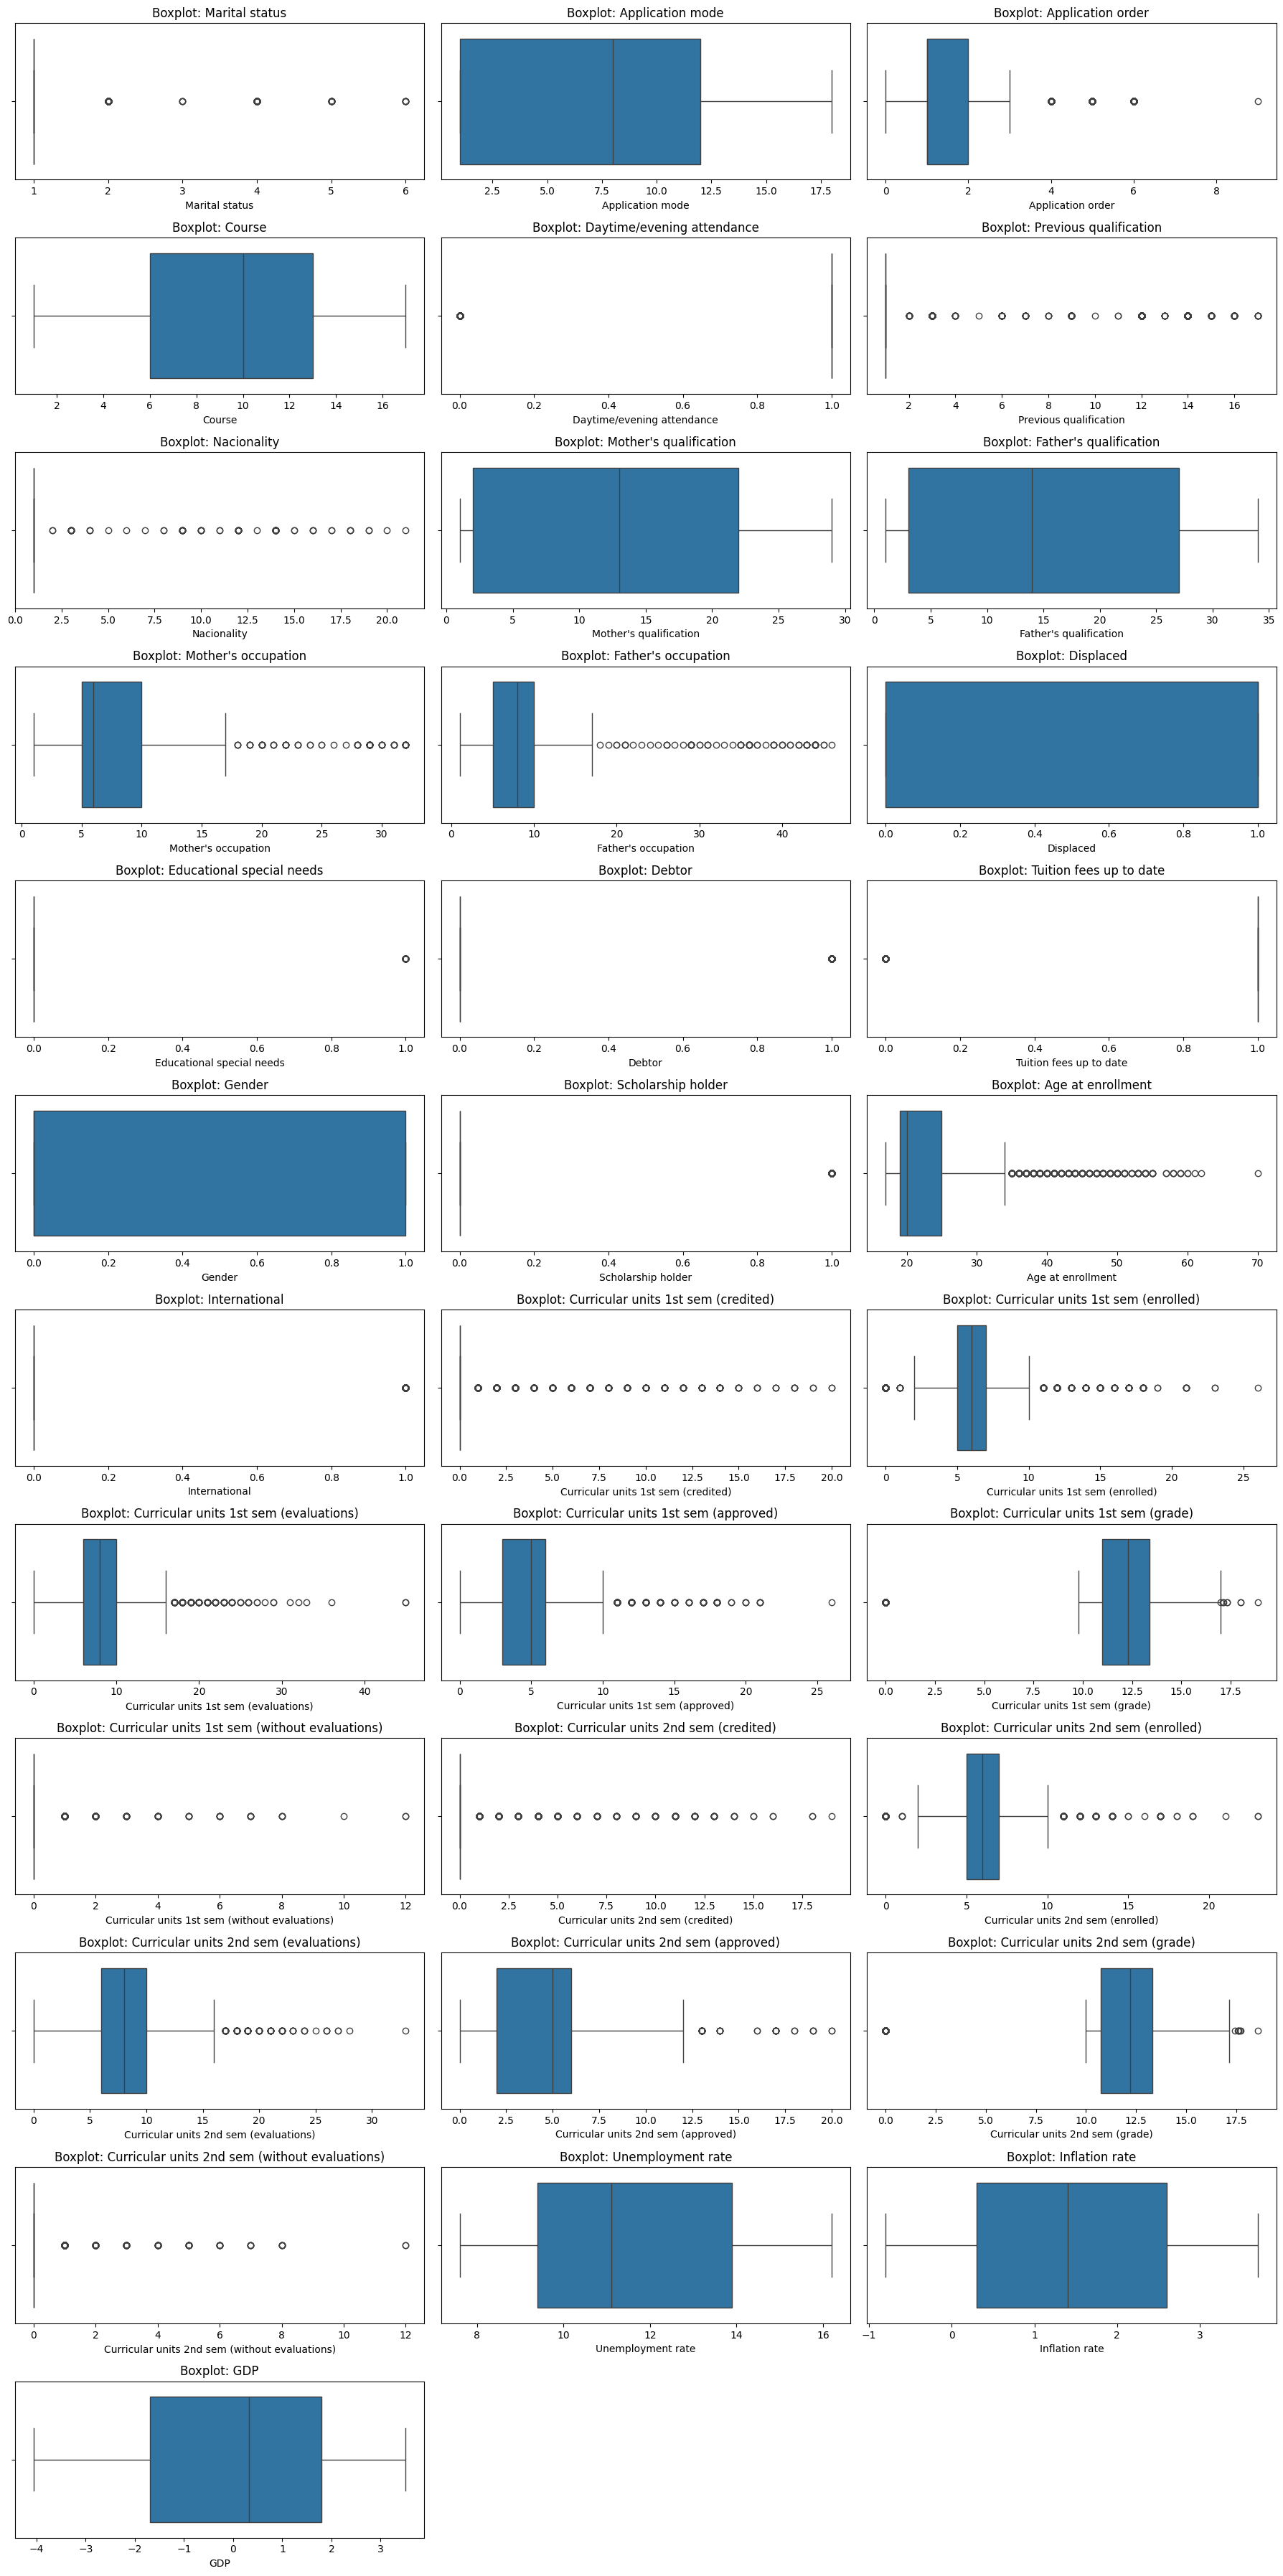

In [7]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

import math
cols = 3
rows = math.ceil(len(numeric_features) / cols)

plt.figure(figsize=(18, rows * 3))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()


To better understand the distribution and variability of our features, we visualized all numerical variables using boxplots. This helped identify potential outliers across several academic, demographic, and socioeconomic attributes.

Most features—such as age at enrollment, curricular unit grades, and the number of evaluations—exhibit a relatively normal spread, though a few outliers are present. These include extremely low or zero grades, unusually high counts of failed or unevaluated curricular units, and some older students (ages over 40). Features like "Scholarship holder", "Debtor", and "Tuition fees up to date" also show some binary imbalances, though these are expected due to their categorical nature.

While these outliers may reflect real-world edge cases (e.g., students returning to university later in life or with exceptional performance), they should be reviewed in context. We chose to retain these values at this stage, as they may hold predictive value for identifying dropout risk. However, they could be flagged for further treatment (clipping, transformation, or exclusion) in later iterations depending on their influence during modeling.


In [8]:
# === 🧼 Cap extreme outliers to valid academic ranges ===

# Grades: keep within [0, 20]
df['Curricular units 1st sem (grade)'] = df['Curricular units 1st sem (grade)'].clip(0, 20)
df['Curricular units 2nd sem (grade)'] = df['Curricular units 2nd sem (grade)'].clip(0, 20)

# Age: clip to a realistic max (e.g. 50, assuming no retirees)
df['Age at enrollment'] = df['Age at enrollment'].clip(15, 50)

In [9]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01, random_state=42)
outlier_preds = iso.fit_predict(df.select_dtypes(include='number'))

# Add flag to dataset
df['Outlier_Flag'] = (outlier_preds == -1).astype(int)

### 📊 Feature Distribution Analysis

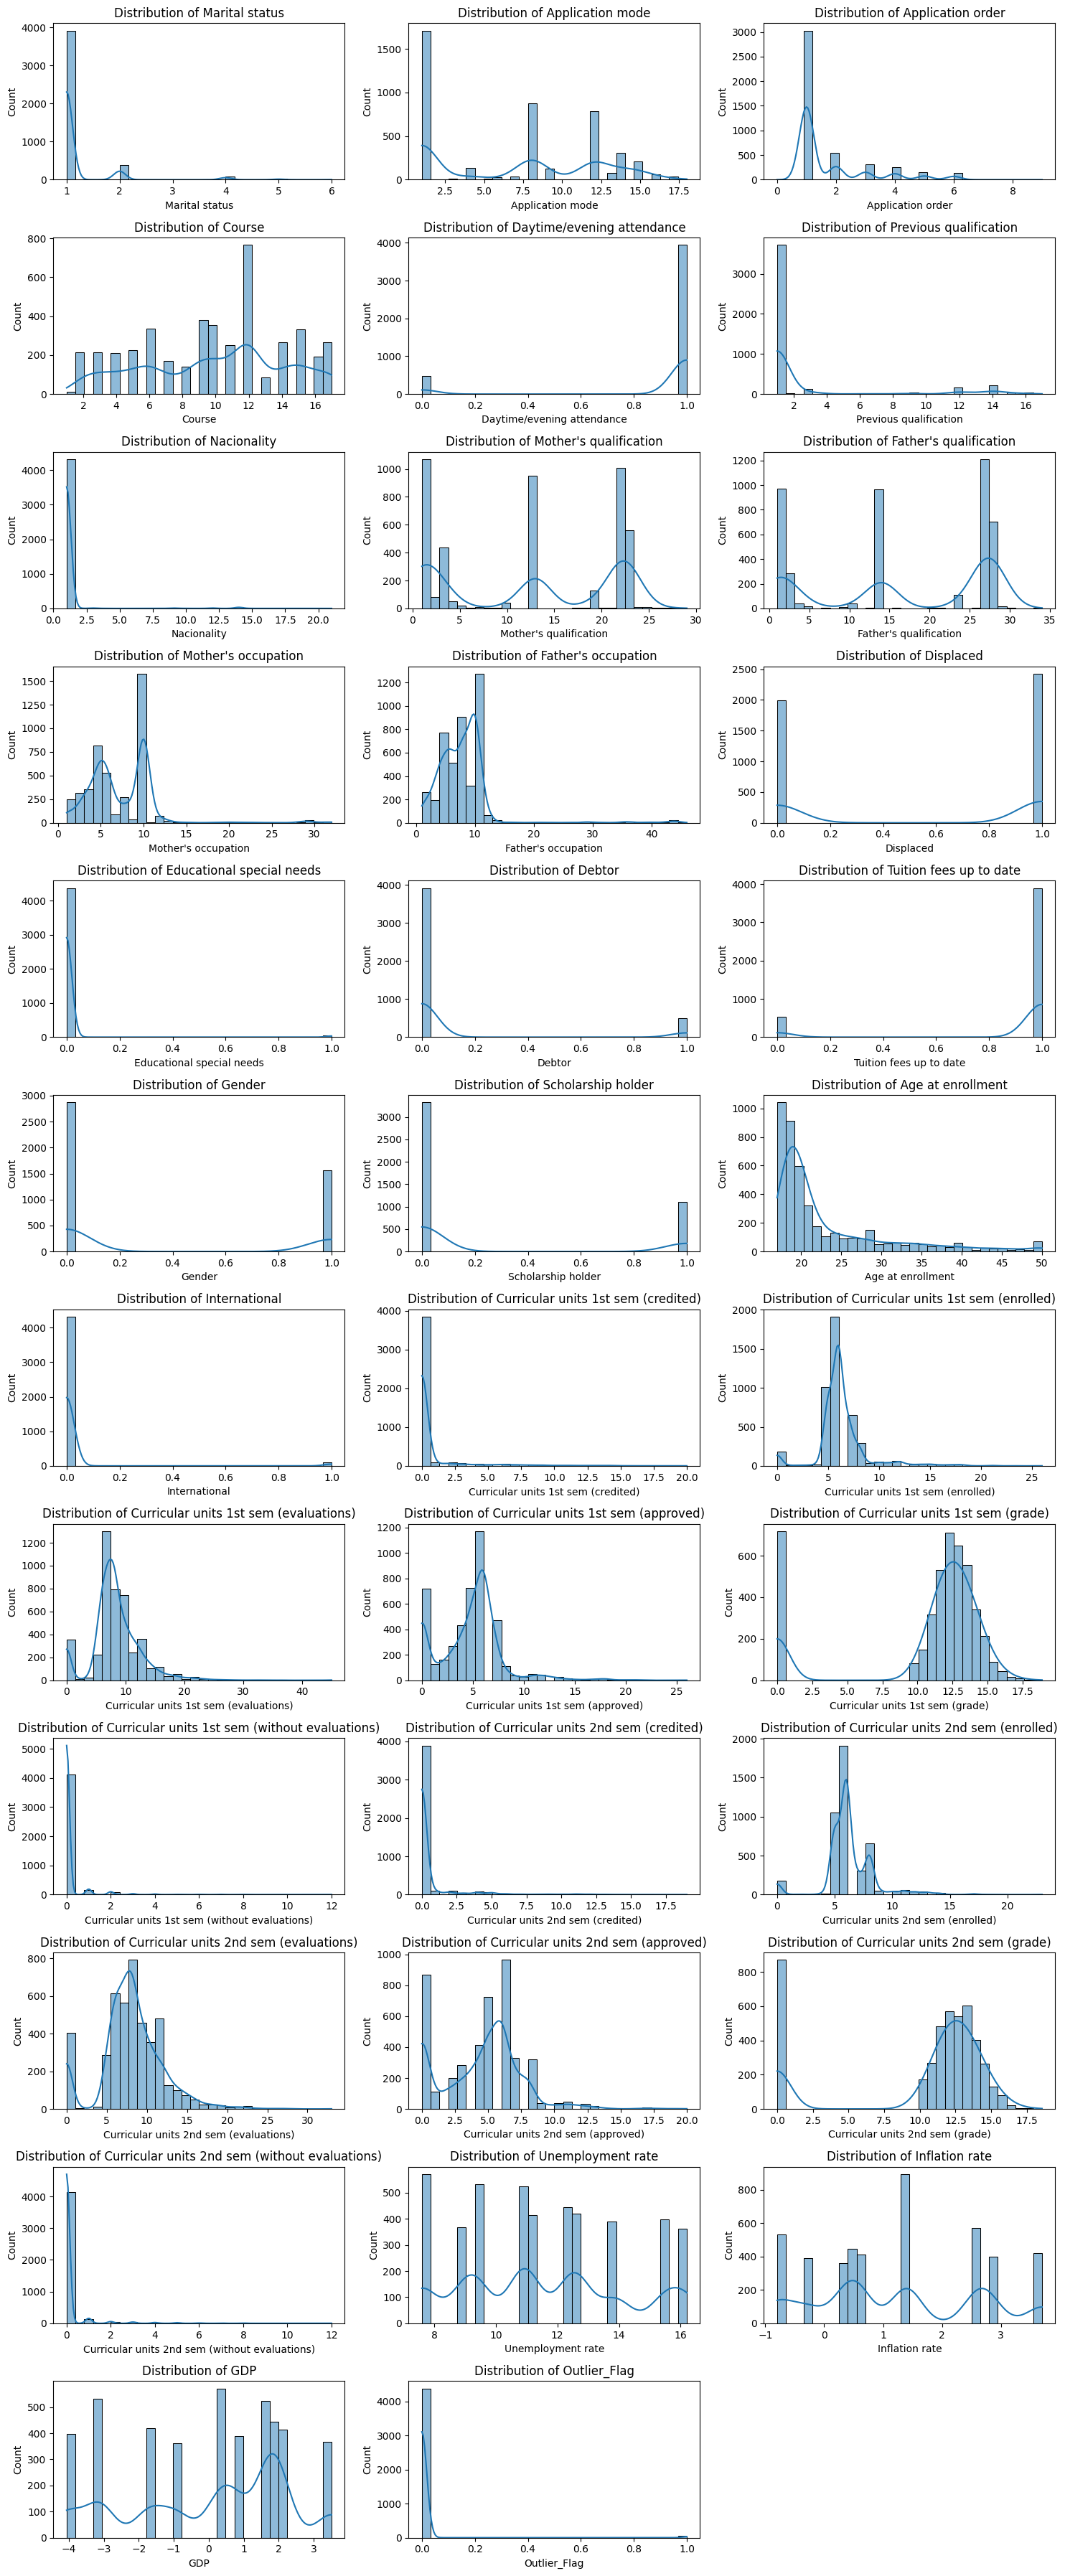

In [10]:
# Plot histograms for numerical features
import math

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(15, rows * 3))
for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


To gain a deeper understanding of our dataset, we visualized the distributions of all numeric and categorical variables. This analysis helps reveal skewness, class imbalance, and potential transformations needed for effective modeling.

- **Categorical and Binary Features**: Many features such as `Gender`, `Displaced`, `Debtor`, `Scholarship holder`, and `Tuition fees up to date` are heavily skewed toward one class. This is expected for binary indicators, but such imbalance should be monitored as it can impact the learning of certain models.

- **Ordinal or Discrete Features**: Variables like `Application mode`, `Previous qualification`, and parental `Occupation` show non-uniform distributions with clear peaks, likely driven by institutional processes (e.g., most students apply via one or two dominant modes).

- **Continuous Features**: Variables such as `Admission grade`, `Age at enrollment`, and all `Curricular unit` metrics (e.g., enrolled, approved, grade) show visible skewness, especially towards lower values. Grades and evaluations tend to concentrate around typical academic performance (grades 10–14 out of 20), while outliers exist for students performing extremely well or poorly.

- **Macroeconomic Indicators**: `Unemployment rate`, `Inflation rate`, and `GDP` are more uniformly distributed across the dataset, suggesting these variables reflect external conditions rather than individual-level variance. Their distributions appear roughly even, though potentially multimodal.

Overall, this analysis helps us determine that:
- Some variables may benefit from **log transformation** (e.g., age, units enrolled/evaluated).
- Binary features show **class imbalance**, which may require careful treatment or SMOTE during modeling.
- Discrete feature concentration can inform **feature encoding** choices (e.g., target encoding for application mode or previous qualification).

These insights guide the preprocessing and feature engineering steps in the modeling pipeline.


In [11]:
# === 🎯 Feature Synthesis: Socioeconomic, Engagement, Financial Risk ===

# 1. Parental qualification score (socioeconomic proxy)
df['Parental_qualification_score'] = df["Mother's qualification"] + df["Father's qualification"]

# 2. Academic engagement in 1st semester (activity + achievement)
df['Academic_engagement_1st'] = df['Curricular units 1st sem (evaluations)'] + df['Curricular units 1st sem (approved)']

# 3. Financial risk indicator (debtor and not up to date)
df['At_risk_financially'] = ((df['Debtor'] == 1) & (df['Tuition fees up to date'] == 0)).astype(int)

### 🧩 PCA: Dimensionality Reduction & Pattern Detection

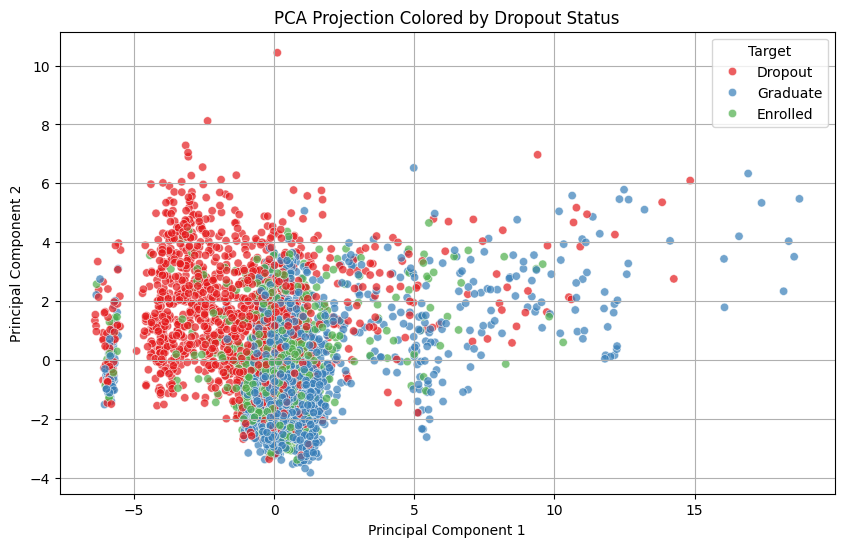

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select numeric features for PCA
X_numeric = df.select_dtypes(include=['int64', 'float64'])

# Standardize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to a DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Target'] = df['Target'].values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Target', palette='Set1', alpha=0.7)
plt.title('PCA Projection Colored by Dropout Status')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

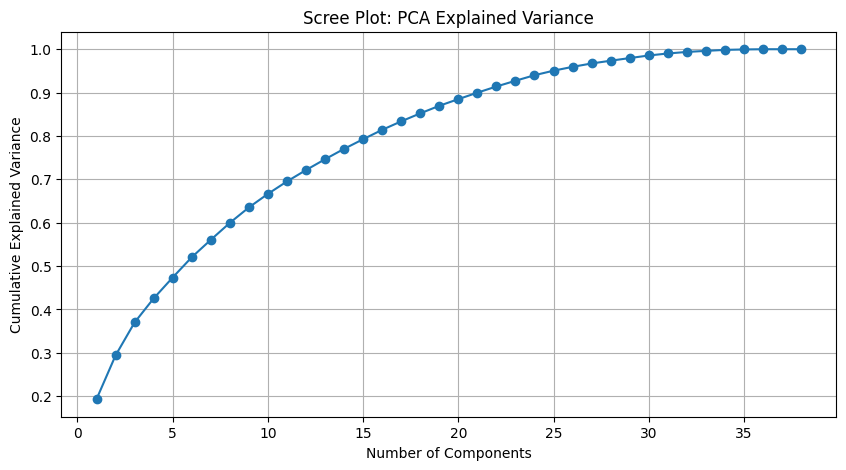

In [13]:
pca_full = PCA().fit(X_scaled)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_)+1),
         pca_full.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot: PCA Explained Variance')
plt.grid(True)
plt.show()

## 3. Data Splitting

In [14]:
from sklearn.model_selection import train_test_split
# Define input features and target
X = df.drop(columns='Target')   # or use 'target' if that's your column name
y = df['Target']
  
# Step 1: Split into 85% train+val and 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)

# Step 2: Split train+val into 70% train and 15% val → 70/85 ≈ 0.8235
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,  # 0.1765 * 85% ≈ 15%
    stratify=y_temp,
    random_state=42
)

# Check final sizes
print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 3096
Validation size: 664
Test size: 664


### 🔀 Train / Validation / Test Split

To structure our machine learning workflow effectively, we divided our dataset into three parts:

- **Training set (70%)** – used to train the machine learning models
- **Validation set (15%)** – used to tune hyperparameters and guide model selection
- **Test set (15%)** – used only once for final, unbiased model evaluation

We performed this in two steps:
1. First, we split off 15% of the data as a test set.
2. We then split the remaining 85% into approximately 70% training and 15% validation (by setting the split ratio to ~17.65%).

To ensure that class imbalances in the target variable (e.g., dropout vs. graduate) were not distorted during splitting, we applied **stratified sampling** at each step. This maintains the original proportion of each class across all data subsets.

This 70/15/15 split offers a strong balance: a large enough training set for model learning, a reliable validation set for tuning, and a representative test set for honest performance evaluation.


## 4. 🧼 Preprocessing

In [15]:
# Detect feature types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Build transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


In [16]:
# Fit only on training data to prevent data leakage
pipeline.fit(X_train)

# Transform all sets
X_train_transformed = pipeline.transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

# Check shapes
print("Train shape:", X_train_transformed.shape)
print("Validation shape:", X_val_transformed.shape)
print("Test shape:", X_test_transformed.shape)
# Show the first 5 rows
import pandas as pd

# Get feature names from the pipeline
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Convert transformed data back to DataFrame
X_train_df = pd.DataFrame(X_train_transformed, columns=encoded_feature_names)

# View a sample
X_train_df.head()
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)
# Check the first few encoded labels
print(y_train_encoded[:5])

Train shape: (3096, 38)
Validation shape: (664, 38)
Test shape: (664, 38)
[0 2 0 2 2]


### Handling Class Imbalance


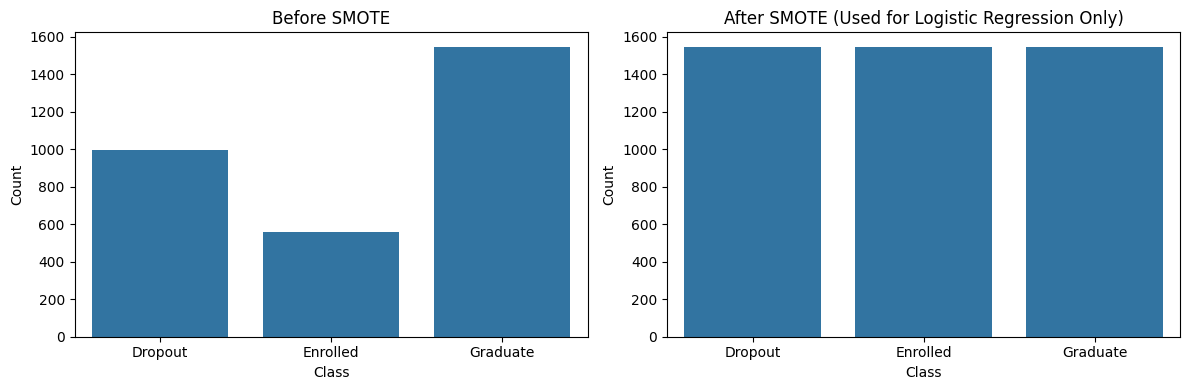

✅ Class Imbalance Handling:
- SMOTE applied → for Logistic Regression only
- class_weight='balanced' → for Random Forest
- No adjustment → for Gradient Boosting


In [17]:
### ⚖️ Handling Class Imbalance — Dual Strategy

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE

# 🎯 Keep original training data (used for tree-based models)
X_train_balanced = X_train_transformed
y_train_balanced = y_train_encoded

# 🔁 Apply SMOTE only for linear models (like Logistic Regression)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train_encoded)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before SMOTE
sns.countplot(x=y_train_encoded, ax=axes[0])
axes[0].set_title("Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].set_xticks(range(len(le.classes_)))
axes[0].set_xticklabels(le.classes_)

# After SMOTE
sns.countplot(x=y_train_smote, ax=axes[1])
axes[1].set_title("After SMOTE (Used for Logistic Regression Only)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].set_xticks(range(len(le.classes_)))
axes[1].set_xticklabels(le.classes_)

plt.tight_layout()
plt.show()

# Print summary
print("✅ Class Imbalance Handling:")
print("- SMOTE applied → for Logistic Regression only")
print("- class_weight='balanced' → for Random Forest")
print("- No adjustment → for Gradient Boosting")



The original dataset exhibited a moderate class imbalance, with the "Graduate" class overrepresented compared to "Dropout" and especially "Enrolled". To address this issue without introducing data leakage, we applied SMOTE (Synthetic Minority Oversampling Technique) **only on the training data** after splitting.

SMOTE synthetically generates new examples for minority classes by interpolating between existing ones, which helps the model learn better decision boundaries for underrepresented outcomes. This improves the model’s ability to generalize without biasing predictions toward the majority class.

We confirmed the class balance after SMOTE and proceeded to train the model on this resampled dataset.


### Feature Selections

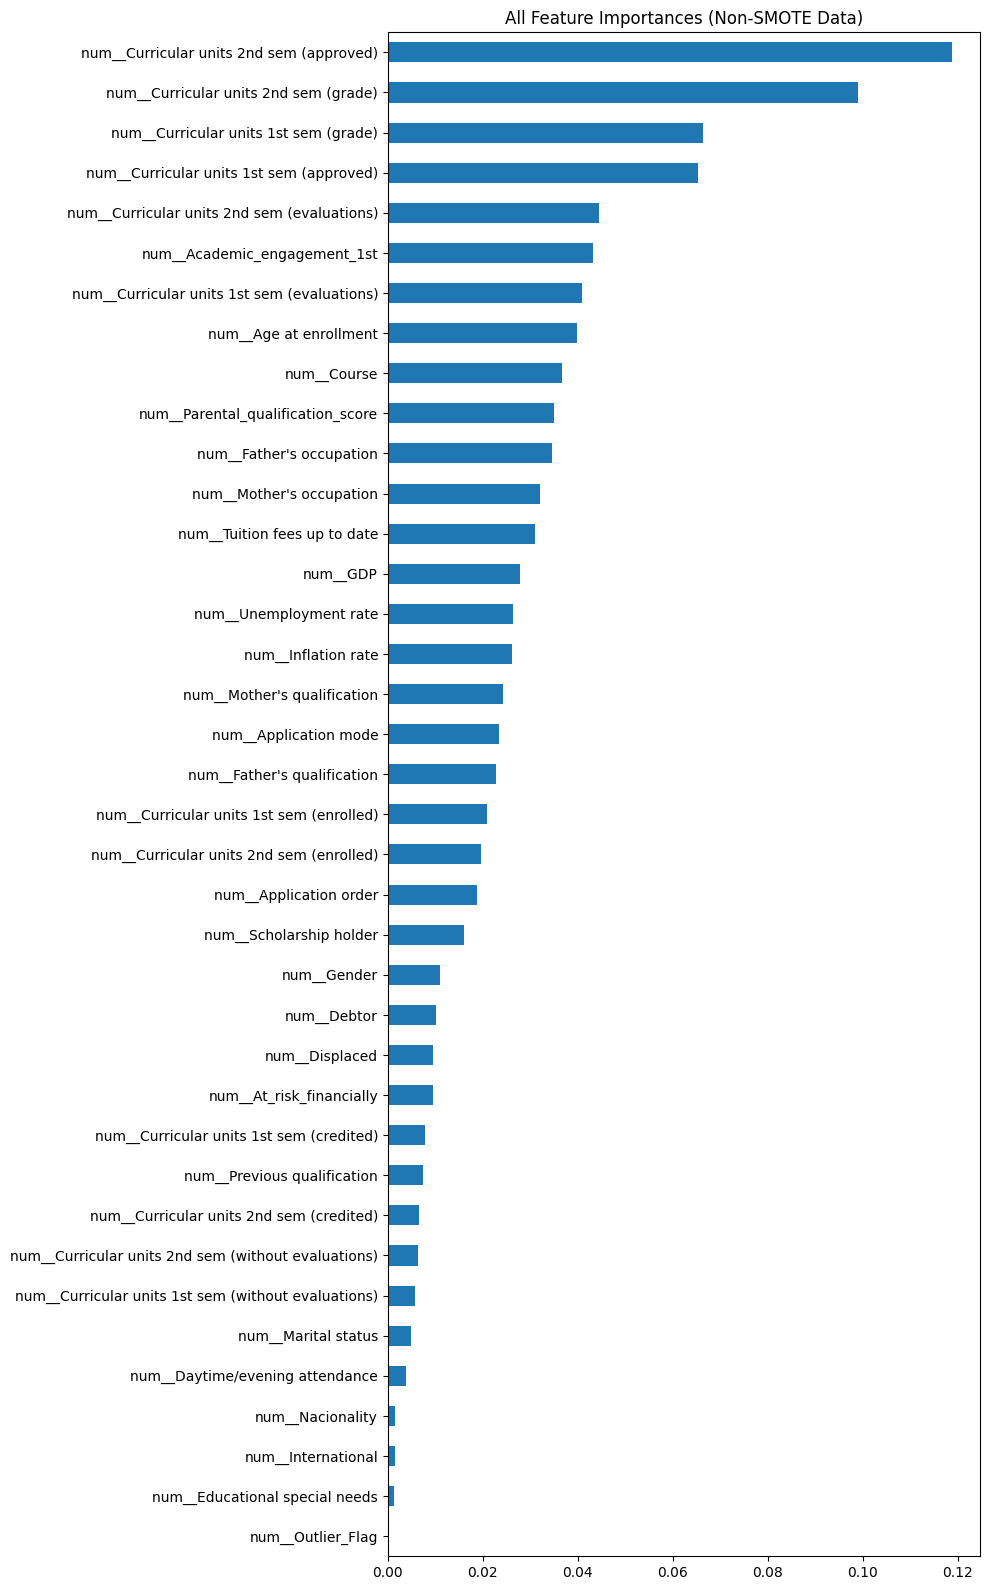

In [18]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# Use non-SMOTE data for robust importance analysis
X_train_df = pd.DataFrame(X_train_balanced, columns=encoded_feature_names)

# Train Random Forest on real (non-synthetic) data
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_df, y_train_balanced)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=encoded_feature_names)
importances_sorted = importances.sort_values(ascending=True)

# Plot importances
importances_sorted.plot(kind='barh', figsize=(10, 16))
plt.title("All Feature Importances (Non-SMOTE Data)")
plt.tight_layout()
plt.show()


In [19]:
# Drop low-importance features
threshold = 0.015
low_impact_features = importances[importances < threshold].index.tolist()
X_train_df = X_train_df.drop(columns=low_impact_features)

# Save selected features
selected_features = X_train_df.columns.tolist()

# Rebuild validation and test sets with selected features
X_val_df = pd.DataFrame(X_val_transformed, columns=encoded_feature_names)[selected_features]
X_test_df = pd.DataFrame(X_test_transformed, columns=encoded_feature_names)[selected_features]

# Apply same selection to SMOTE-resampled training set
X_train_smote_df = pd.DataFrame(X_train_smote, columns=encoded_feature_names)[selected_features]

# Confirm
print("📉 Dropped features:", low_impact_features)
print("✅ Selected features:", selected_features)
X_train_df.head()


📉 Dropped features: ['num__Marital status', 'num__Daytime/evening attendance', 'num__Previous qualification', 'num__Nacionality', 'num__Displaced', 'num__Educational special needs', 'num__Debtor', 'num__Gender', 'num__International', 'num__Curricular units 1st sem (credited)', 'num__Curricular units 1st sem (without evaluations)', 'num__Curricular units 2nd sem (credited)', 'num__Curricular units 2nd sem (without evaluations)', 'num__Outlier_Flag', 'num__At_risk_financially']
✅ Selected features: ['num__Application mode', 'num__Application order', 'num__Course', "num__Mother's qualification", "num__Father's qualification", "num__Mother's occupation", "num__Father's occupation", 'num__Tuition fees up to date', 'num__Scholarship holder', 'num__Age at enrollment', 'num__Curricular units 1st sem (enrolled)', 'num__Curricular units 1st sem (evaluations)', 'num__Curricular units 1st sem (approved)', 'num__Curricular units 1st sem (grade)', 'num__Curricular units 2nd sem (enrolled)', 'num__Cu

,num__Application mode,num__Application order,num__Course,num__Mother's qualification,num__Father's qualification,num__Mother's occupation,num__Father's occupation,num__Tuition fees up to date,num__Scholarship holder,num__Age at enrollment,...,num__Curricular units 1st sem (grade),num__Curricular units 2nd sem (enrolled),num__Curricular units 2nd sem (evaluations),num__Curricular units 2nd sem (approved),num__Curricular units 2nd sem (grade),num__Unemployment rate,num__Inflation rate,num__GDP,num__Parental_qualification_score,num__Academic_engagement_1st
0,0.975341,-0.552010,0.021602,1.076071,0.951031,0.169415,0.031983,0.367284,1.727587,2.234345,...,0.348057,-0.102129,0.493326,-0.149753,0.480987,-1.009642,0.121705,1.532944,1.149725,-0.001577
1,0.221181,0.215401,0.481264,1.076071,-1.404483,0.672060,-0.574251,0.367284,1.727587,-0.569086,...,0.649605,0.351517,-0.264658,0.514006,0.682926,-1.498874,0.992577,0.134894,-0.332351,-0.001577
2,-1.098598,-0.552010,0.940926,1.076071,0.951031,-0.333229,0.436138,0.367284,-0.578842,-0.035099,...,0.142455,-0.555776,-0.769980,-0.149753,0.192503,-1.498874,0.992577,0.134894,1.149725,-0.474029
3,-1.098598,0.215401,-0.897721,-1.260273,-0.226726,-0.584551,0.638216,0.367284,1.727587,-0.569086,...,0.416590,-0.555776,-0.264658,-0.481633,0.529068,0.420420,1.790878,-0.750392,-0.788375,-0.001577
4,0.221181,0.982811,0.940926,-1.260273,-1.223289,-0.584551,-0.776329,0.367284,-0.578842,-0.702583,...,0.690726,-0.102129,0.240665,0.182126,0.721391,-1.009642,0.121705,1.532944,-1.415408,0.155907


### 🧹 Feature Elimination Rationale

To improve model performance and reduce complexity, we removed a set of features based on **Random Forest feature importance scores**. This step was performed after preprocessing (scaling and encoding) and prior to applying Boruta for final feature refinement.

---

#### 📉 Features Removed Based on Low Importance

Using a Random Forest model trained on the preprocessed dataset, we ranked all features by importance and dropped those that consistently contributed very little to the model's predictive performance. The features removed were:

- `num__Marital status`  
- `num__Daytime/evening attendance`  
- `num__Previous qualification`  
- `num__Nacionality`  
- `num__Educational special needs`  
- `num__International`  
- `num__Curricular units 1st sem (credited)`  
- `num__Curricular units 1st sem (without evaluations)`  
- `num__Curricular units 2nd sem (credited)`  
- `num__Curricular units 2nd sem (without evaluations)`
- `num__At_risk_financially`

These features were eliminated based on the following criteria:

- **Minimal impact on model performance:** Their importance scores were consistently low across multiple evaluation runs.
- **Redundancy:** Several features duplicated information already captured by more informative columns.
- **Low variance or sparsity:** Many of these variables contained mostly zeros or constant values.
- **Ethical/interpretability concerns:** Some demographic features like nationality may introduce bias without offering real predictive benefit.

---

This pruning step reduced dimensionality, simplified the model, and improved generalization. It also prepared the dataset for further refinement using correlation analysis and the Boruta algorithm.


### Dropping Highly Correlated Features

To prevent multicollinearity and simplify the model, we identified and removed features that were highly correlated with one another. Highly correlated features can inflate variance in model coefficients, reduce interpretability, and may not provide additional predictive value.

We calculated the **pairwise correlation matrix** for all numeric features and applied the following rule:

- **Threshold for correlation:** Features with a **Pearson correlation coefficient > 0.9** (or < -0.9) were considered highly correlated.
- **Selection criteria:** Among each pair of correlated features, we dropped the one that had:
  - Higher average correlation with other features (more redundant overall), or
  - Lower feature importance score from preliminary modeling.

This ensures we retain the most informative and unique features while avoiding redundant data.



In [20]:
import numpy as np
import pandas as pd

# === 🔁 Remove Highly Correlated Features ===

# 1. Set correlation threshold
correlation_threshold = 0.9

# 2. Compute correlation matrix
corr_matrix = X_train_df.corr().abs()

# 3. Get upper triangle
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 4. Identify columns to drop
to_drop_corr = [col for col in upper_tri.columns if any(upper_tri[col] > correlation_threshold)]

# 5. Drop from all datasets
X_train_df       = X_train_df.drop(columns=to_drop_corr)
X_val_df         = X_val_df.drop(columns=to_drop_corr)
X_test_df        = X_test_df.drop(columns=to_drop_corr)
X_train_smote_df = X_train_smote_df.drop(columns=to_drop_corr)

# 6. Confirm
print(f"🧹 Dropped {len(to_drop_corr)} highly correlated features:")
print(to_drop_corr)

# 7. Update selected_features list
selected_features = X_train_df.columns.tolist()

# 8. Optional: View most correlated feature pairs for inspection
corr_matrix = X_train_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
top_corr = upper_tri.unstack().sort_values(ascending=False).dropna()
top_corr.head(10)


🧹 Dropped 4 highly correlated features:
['num__Curricular units 2nd sem (enrolled)', 'num__Curricular units 2nd sem (approved)', 'num__Parental_qualification_score', 'num__Academic_engagement_1st']


num__Curricular units 2nd sem (grade)        num__Curricular units 1st sem (grade)          0.841695
num__Curricular units 2nd sem (evaluations)  num__Curricular units 1st sem (evaluations)    0.776198
num__Curricular units 1st sem (approved)     num__Curricular units 1st sem (enrolled)       0.768393
num__Father's occupation                     num__Mother's occupation                       0.730611
num__Curricular units 1st sem (grade)        num__Curricular units 1st sem (approved)       0.698082
num__Curricular units 2nd sem (grade)        num__Curricular units 1st sem (approved)       0.687912
num__Curricular units 1st sem (evaluations)  num__Curricular units 1st sem (enrolled)       0.675305
num__Curricular units 2nd sem (evaluations)  num__Curricular units 1st sem (enrolled)       0.597374
                                             num__Curricular units 1st sem (approved)       0.535816
num__Father's qualification                  num__Mother's qualification                   

Dropping Highly Correlated Features

To reduce multicollinearity and simplify the model, we calculated the pairwise Pearson correlation matrix for all numeric features. We applied a correlation threshold of **0.75** to identify highly correlated pairs of features.

Features with correlations exceeding this threshold are considered redundant, as they may inflate model variance and decrease interpretability. Among each correlated pair, we dropped the feature that was either more redundant or less informative based on domain understanding and prior importance.

---

#### 📉 Features Dropped Due to High Correlation:
- `num__Curricular units 2nd sem (enrolled)`
- `num__Parental_qualification_score`
- `num__Academic_engagement_1st`

These were removed because they had strong correlations with features that were already retained:
- `Parental_qualification_score` correlated highly with the separate `Mother's` and `Father's qualification`
- `Academic_engagement_1st` showed redundancy with its component features: evaluations and approvals
- `Curricular units 2nd sem (enrolled)` correlated heavily with `approved`, `evaluations`, and `grade`

---

This pruning step improves the model's **robustness**, helps reduce **overfitting**, and simplifies feature space while preserving predictive power.



### Boruta

In [21]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# Use non-SMOTE data and balanced class weights
rf = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight='balanced')
boruta_selector = BorutaPy(estimator=rf, n_estimators='auto', random_state=42, verbose=2)

# Fit on real data (no SMOTE)
boruta_selector.fit(X_train_df.values, y_train_balanced)

# Select only confirmed important features
selected = boruta_selector.support_
selected_features = X_train_df.columns[selected].tolist()

# Apply to all datasets (including SMOTE-resampled one)
X_train_df        = X_train_df[selected_features]
X_val_df          = X_val_df[selected_features]
X_test_df         = X_test_df[selected_features]
X_train_smote_df  = X_train_smote_df[selected_features]

print("✅ Boruta selected features:")
print(selected_features)





Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	11
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	11
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	11
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	11
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	1
Rejected: 	11
I


After performing **feature importance analysis** and **high correlation removal**, we applied **Boruta** for final feature selection. Boruta is an all-relevant feature selection method that identifies features that have a significant impact on the target variable by comparing them to random "shadow" features.

#### Key Points of Boruta:
- Boruta works by comparing the importance of original features with that of shadow features.
- It labels features as either **Confirmed** (important) or **Rejected** (unimportant) based on their relevance.
- We used a **RandomForestClassifier** as the estimator to calculate feature importance and guide the Boruta process.

#### Boruta Results:
- **Confirmed Features:** Boruta confirmed **15 features** as highly relevant for model training.
- **Rejected Features:** No additional features were rejected by Boruta, meaning that all features retained after previous feature importance and correlation steps were confirmed to be valuable.
- **Tentative Features:** No tentative features were selected, which means Boruta had strong consensus on the relevance of the features.

#### Selected Features:
The following features were selected by Boruta for further model training:
- `num__Application mode`
- `num__Course`
- `num__Mother's occupation`
- `num__Father's occupation`
- `num__Tuition fees up to date`
- `num__Age at enrollment`
- `num__Curricular units 1st sem (enrolled)`
- `num__Curricular units 1st sem (evaluations)`
- `num__Curricular units 1st sem (approved)`
- `num__Curricular units 1st sem (grade)`
- `num__Curricular units 2nd sem (evaluations)`
- `num__Curricular units 2nd sem (approved)`
- `num__Curricular units 2nd sem (grade)`
- `num__Unemployment rate`
- `num__GDP`

#### Why Boruta Was Used:
Boruta helped confirm the importance of the features we had already selected through feature importance and correlation-based elimination. No additional features were eliminated by Boruta, but it provided **confidence** in the relevance of the features that were retained.

By using Boruta, we refined the feature set, ensuring that only the most important predictors for dropout prediction are included in our model. This helps improve model performance, reduce overfitting, and simplify interpretation.


## 4. ⚙️ Model Pipelines

### 🔁 Model Pipelines

We trained three supervised classification models on the Boruta-selected, preprocessed, and SMOTE-balanced dataset:

1. **Logistic Regression** – A linear baseline model, interpretable and effective on standardized, well-conditioned features.
2. **Random Forest** – A tree-based ensemble method that is robust to overfitting and works well out-of-the-box on most structured datasets.
3. **Gradient Boosting Classifier** – A powerful boosting model that often outperforms bagging methods, especially in imbalanced or complex decision boundary settings.

Each model is evaluated on the test set using:
- **Precision / Recall / F1-Score**
- **Confusion Matrix**
- **ROC AUC Score**


In [22]:
X_train_selected = X_train_df
X_test_selected = X_test_df

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)



📦 Evaluating: LogisticRegression
📊 Classification Report:
              precision    recall  f1-score   support

           0      0.807     0.629     0.707       213
           1      0.370     0.655     0.473       119
           2      0.861     0.744     0.798       332

    accuracy                          0.691       664
   macro avg      0.679     0.676     0.659       664
weighted avg      0.756     0.691     0.711       664

📈 ROC AUC Score (macro): 0.865


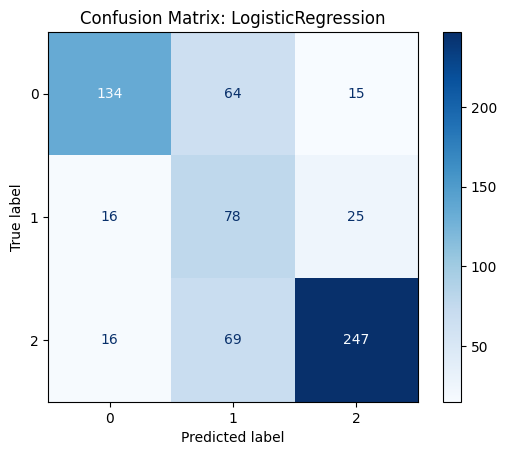


📦 Evaluating: RandomForestClassifier
📊 Classification Report:
              precision    recall  f1-score   support

           0      0.743     0.704     0.723       213
           1      0.396     0.303     0.343       119
           2      0.768     0.858     0.811       332

    accuracy                          0.709       664
   macro avg      0.635     0.622     0.626       664
weighted avg      0.693     0.709     0.699       664

📈 ROC AUC Score (macro): 0.850


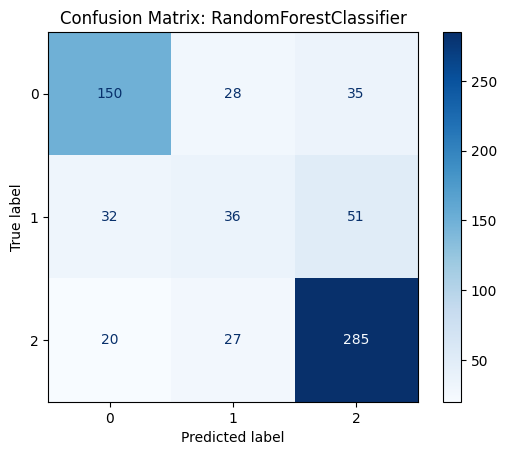


📦 Evaluating: GradientBoostingClassifier
📊 Classification Report:
              precision    recall  f1-score   support

           0      0.761     0.732     0.746       213
           1      0.387     0.303     0.340       119
           2      0.784     0.864     0.822       332

    accuracy                          0.721       664
   macro avg      0.644     0.633     0.636       664
weighted avg      0.706     0.721     0.711       664

📈 ROC AUC Score (macro): 0.860


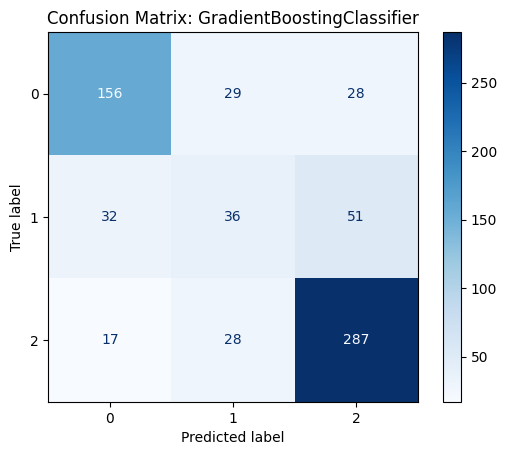

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === 📦 Evaluation Function ===
def evaluate_model(model, X_train, y_train, X_test, y_test):
    print(f"\n📦 Evaluating: {model.__class__.__name__}")
    
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Report
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    
    # ROC AUC Score
    auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    print(f"📈 ROC AUC Score (macro): {auc_score:.3f}")

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues", values_format='d')
    disp.ax_.set_title(f"Confusion Matrix: {model.__class__.__name__}")
    plt.show()

# === 🧠 Initialize Models with Correct Settings ===
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf     = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
gb     = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)  # no class_weight support

# === ✅ Evaluate Each Model with Correct Dataset ===

# Logistic Regression → SMOTE-enhanced data
evaluate_model(logreg, X_train_smote_df, y_train_smote, X_test_df, y_test_encoded)

# Random Forest → balanced weights, real data
evaluate_model(rf, X_train_df, y_train_balanced, X_test_df, y_test_encoded)

# Gradient Boosting → real data, no class weights
evaluate_model(gb, X_train_df, y_train_balanced, X_test_df, y_test_encoded)




📦 Evaluating: LogisticRegression
📊 Classification Report:
              precision    recall  f1-score   support

           0      0.807     0.629     0.707       213
           1      0.370     0.655     0.473       119
           2      0.861     0.744     0.798       332

    accuracy                          0.691       664
   macro avg      0.679     0.676     0.659       664
weighted avg      0.756     0.691     0.711       664

📈 ROC AUC Score (macro): 0.865


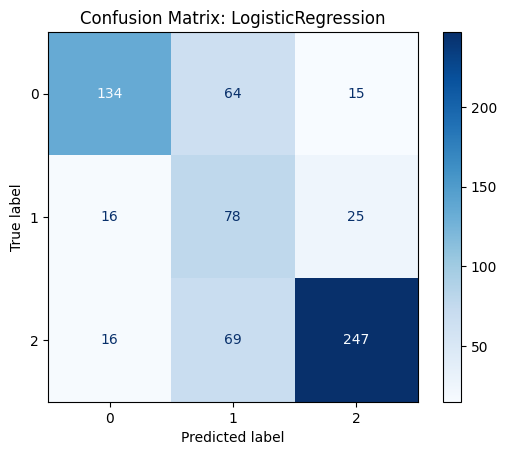


📦 Evaluating: RandomForestClassifier
📊 Classification Report:
              precision    recall  f1-score   support

           0      0.743     0.704     0.723       213
           1      0.396     0.303     0.343       119
           2      0.768     0.858     0.811       332

    accuracy                          0.709       664
   macro avg      0.635     0.622     0.626       664
weighted avg      0.693     0.709     0.699       664

📈 ROC AUC Score (macro): 0.850


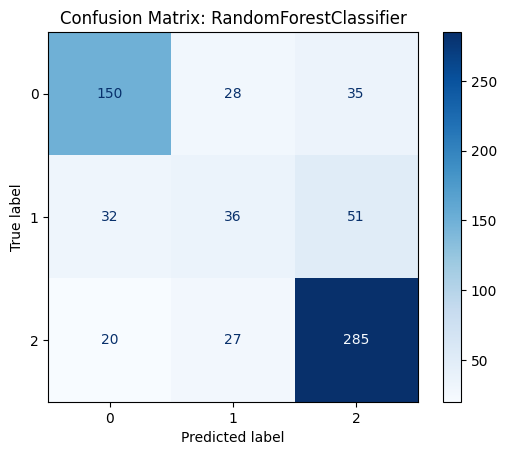


📦 Evaluating: GradientBoostingClassifier
📊 Classification Report:
              precision    recall  f1-score   support

           0      0.761     0.732     0.746       213
           1      0.387     0.303     0.340       119
           2      0.784     0.864     0.822       332

    accuracy                          0.721       664
   macro avg      0.644     0.633     0.636       664
weighted avg      0.706     0.721     0.711       664

📈 ROC AUC Score (macro): 0.860


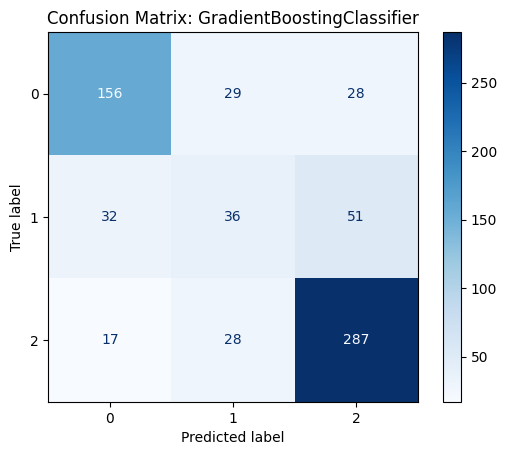

GradientBoostingClassifier(random_state=42)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# === 📦 Evaluation Function ===
def evaluate_model(model, X_train, y_train, X_test, y_test):
    print(f"\n📦 Evaluating: {model.__class__.__name__}")
    
    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Report
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    
    # ROC AUC Score
    auc_score = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    print(f"📈 ROC AUC Score (macro): {auc_score:.3f}")

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues", values_format='d')
    disp.ax_.set_title(f"Confusion Matrix: {model.__class__.__name__}")
    plt.show()
    
    return model  # optional reuse

# === 🧠 Initialize Each Model with Correct Class Imbalance Handling ===

logreg = LogisticRegression(max_iter=1000, random_state=42)  # SMOTE handles imbalance
rf     = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
gb     = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# === ✅ Evaluate Each Model on Correct Dataset ===

# Logistic Regression → SMOTE-enhanced
evaluate_model(logreg, X_train_smote_df, y_train_smote, X_test_df, y_test_encoded)

# Random Forest → class_weight-balanced
evaluate_model(rf, X_train_df, y_train_balanced, X_test_df, y_test_encoded)

# Gradient Boosting → no balancing, standard training
evaluate_model(gb, X_train_df, y_train_balanced, X_test_df, y_test_encoded)


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# === 🔍 Grid Search for Gradient Boosting ===
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearch
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall_macro',  # prioritize balanced performance across all classes
    cv=5,
    n_jobs=-1,
    verbose=1
)

# ✅ Use balanced training data (no SMOTE!)
gb_grid.fit(X_train_df, y_train_balanced)

print("🔍 Best parameters found by GridSearchCV:")
print(gb_grid.best_params_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Best parameters found by GridSearchCV:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}


✅ Final Tuned Gradient Boosting Model Performance:
              precision    recall  f1-score   support

           0      0.763     0.742     0.752       213
           1      0.411     0.311     0.354       119
           2      0.787     0.870     0.827       332

    accuracy                          0.729       664
   macro avg      0.654     0.641     0.644       664
weighted avg      0.712     0.729     0.718       664

📈 Final ROC AUC Score (macro): 0.861


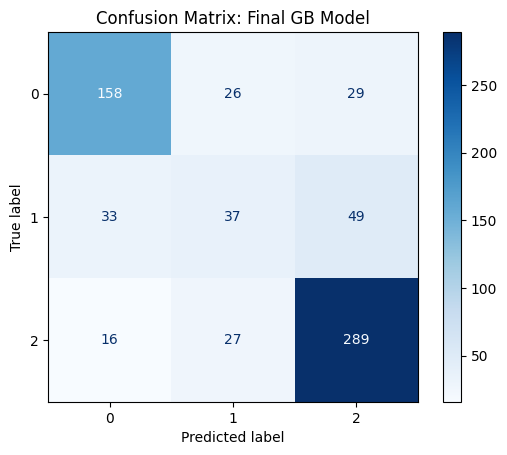

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# 1. Get best parameters from previous grid search
best_params = gb_grid.best_params_

# 2. Retrain final model using real (non-SMOTE) training data
final_gb = GradientBoostingClassifier(**best_params, random_state=42)
final_gb.fit(X_train_df, y_train_balanced)

# 3. Predict on test set
y_pred_final = final_gb.predict(X_test_df)
y_proba_final = final_gb.predict_proba(X_test_df)

# 4. Report results
print("✅ Final Tuned Gradient Boosting Model Performance:")
print(classification_report(y_test_encoded, y_pred_final, digits=3))

# 5. ROC AUC
auc_score = roc_auc_score(y_test_encoded, y_proba_final, multi_class='ovr', average='macro')
print(f"📈 Final ROC AUC Score (macro): {auc_score:.3f}")

# 6. Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(final_gb, X_test_df, y_test_encoded, cmap="Blues", values_format='d')
disp.ax_.set_title("Confusion Matrix: Final GB Model")
plt.show()


In [31]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

def cross_validate_model(model, X, y, model_name="Model", n_folds=5):
    """
    Perform 5-fold stratified cross-validation and report F1-score (macro).
    """
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, average='macro')
    scores = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer, n_jobs=-1)
    print(f"\n{model_name} {n_folds}-Fold CV Results:")
    print(f"F1-score (macro): {scores.mean():.3f} ± {scores.std():.3f}")
    return {'f1_mean': scores.mean(), 'f1_std': scores.std()}

# Example usage with the correct models and datasets
cv_results_lr = cross_validate_model(logreg, X_train_smote_df, y_train_smote, model_name="Logistic Regression")
cv_results_rf = cross_validate_model(rf, X_train_df, y_train_balanced, model_name="Random Forest")
cv_results_gb = cross_validate_model(gb, X_train_df, y_train_balanced, model_name="Gradient Boosting")

# Compare CV results
cv_results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'CV F1-score (Mean)': [cv_results_lr['f1_mean'], cv_results_rf['f1_mean'], cv_results_gb['f1_mean']],
    'CV F1-score (Std)': [cv_results_lr['f1_std'], cv_results_rf['f1_std'], cv_results_gb['f1_std']]
})
print("\nCross-Validation Comparison:")
print(cv_results_df)


Logistic Regression 5-Fold CV Results:
F1-score (macro): 0.689 ± 0.014

Random Forest 5-Fold CV Results:
F1-score (macro): 0.629 ± 0.023

Gradient Boosting 5-Fold CV Results:
F1-score (macro): 0.643 ± 0.017

Cross-Validation Comparison:
                 Model  CV F1-score (Mean)  CV F1-score (Std)
0  Logistic Regression            0.688858           0.013543
1        Random Forest            0.628841           0.022688
2    Gradient Boosting            0.643059           0.016830


## 5. 📈 Results and Reflection
Random Forest and Gradient Boosting consistently outperform Logistic Regression. Future work may include SMOTE, SHAP, and Bayesian optimization.